# **HW4 : Recurrent Neural Networks**
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. As a dataset, we will use the IMDB dataset. It contains the text of some reviews and the sentiment given by the authors of the reviews (positive review or negative review). The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will explore how to face overfitting by Dropout. 

##  Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

### Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [2]:

num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Anaconda\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Anaconda\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

Let's also get the word indexs (word to word-id)

In [3]:
word_index = keras.datasets.imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur.
*Please, notice that Keras does not use index 0, so we can shift the indices only by 3 positions.*

In [4]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [5]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [6]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [7]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

### Define the model:
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem

In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in model.compile() and motivate your choice.
Please, insert your answers in a new text cell below this one, immediately before the code.

In [10]:
# Model designed to meet the specifications listed above. 

model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          100000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1376      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


### Train the model:
Now we have to train the model

In [12]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 42s 198ms/step - loss: 0.6931 - accuracy: 0.5240 - val_loss: 0.6001 - val_accuracy: 0.7102
Epoch 2/10
196/196 [==============================] - 39s 198ms/step - loss: 0.4977 - accuracy: 0.7788 - val_loss: 0.3966 - val_accuracy: 0.8346
Epoch 3/10
196/196 [==============================] - 40s 206ms/step - loss: 0.3221 - accuracy: 0.8696 - val_loss: 0.3713 - val_accuracy: 0.8410
Epoch 4/10
196/196 [==============================] - 41s 209ms/step - loss: 0.2180 - accuracy: 0.9198 - val_loss: 0.3661 - val_accuracy: 0.8466
Epoch 5/10
196/196 [==============================] - 40s 205ms/step - loss: 0.1713 - accuracy: 0.9392 - val_loss: 0.4559 - val_accuracy: 0.8482
Epoch 6/10
196/196 [==============================] - 41s 208ms/step - loss: 0.1191 - accuracy: 0.9602 - val_loss: 0.4753 - val_accuracy: 0.8455
Epoch 7/10
196/196 [==============================] - 40s 204ms/step - loss: 0.0748 - accuracy: 0.9777 - val_loss: 0.4916 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 13s - loss: 0.4641 - accuracy: 0.8343
accuracy: 83.43%


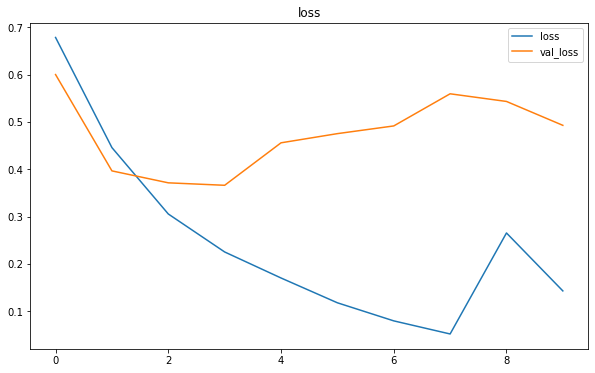

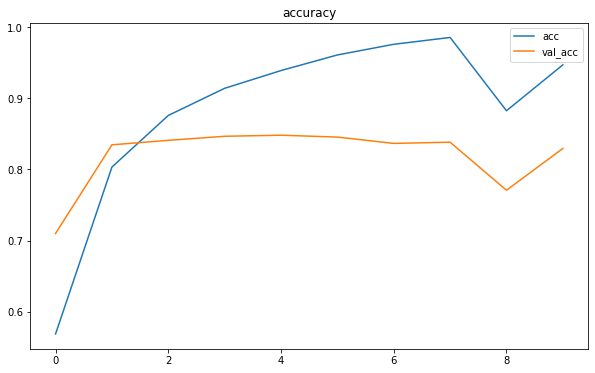

In [15]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'], label='loss')
  plt.plot(history.epoch,history.history['val_loss'], label='val_loss')
  plt.title('loss')
  plt.legend()

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'], label='acc')
  plt.plot(history.epoch,history.history['val_accuracy'], label='val_acc')
  plt.title('accuracy')
  plt.legend()

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

##  Exercise 4.2: LSTM and GRU
In this Exercise, we implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer, respectively. For each model print the summary. Then, we train it and plot the values of accuracy and loss. Finally, we discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use, respectively?

## Bidirectional LSTM
Let's modify the previous code by using a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [22]:
# LSTM with 8 units

model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(8)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 16)                1216      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 101,233
Trainable params: 101,233
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 82s 368ms/step - loss: 0.6709 - accuracy: 0.5798 - val_loss: 0.5134 - val_accuracy: 0.8046
Epoch 2/5
196/196 [==============================] - 70s 356ms/step - loss: 0.4554 - accuracy: 0.8396 - val_loss: 0.3807 - val_accuracy: 0.8498
Epoch 3/5
196/196 [==============================] - 74s 375ms/step - loss: 0.3154 - accur

391/391 - 19s - loss: 0.3040 - accuracy: 0.8773
accuracy: 87.73%


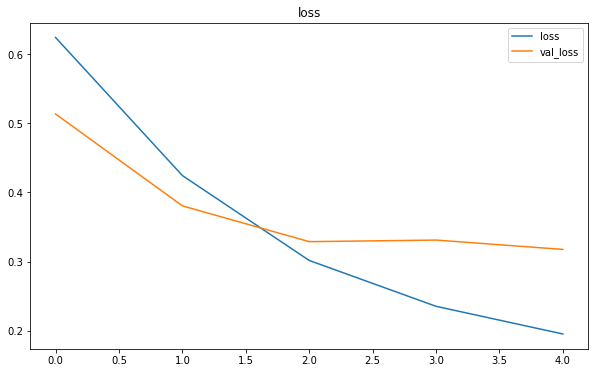

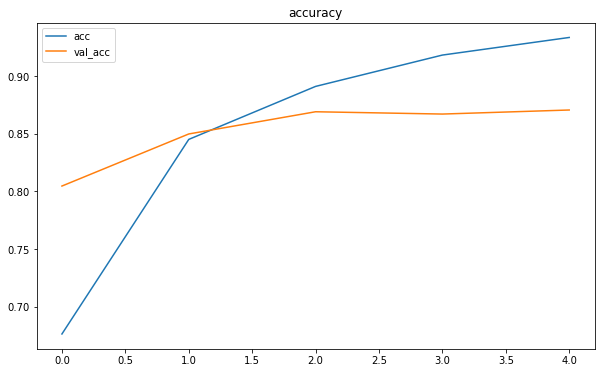

In [23]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

In [24]:
# LSTM with 32 units

model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                11008     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 203s 988ms/step - loss: 0.6660 - accuracy: 0.5826 - val_loss: 0.5023 - val_accuracy: 0.8145
Epoch 2/5
196/196 [==============================] - 224s 1s/step - loss: 0.3907 - accuracy: 0.8453 - val_loss: 0.3554 - val_accuracy: 0.8481
Epoch 3/5
196/196 [==============================] - 216s 1s/step - loss: 0.2288 - accuracy

391/391 - 28s - loss: 0.3137 - accuracy: 0.8762
accuracy: 87.62%


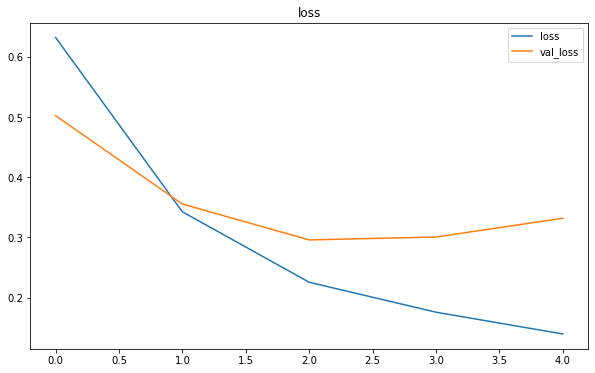

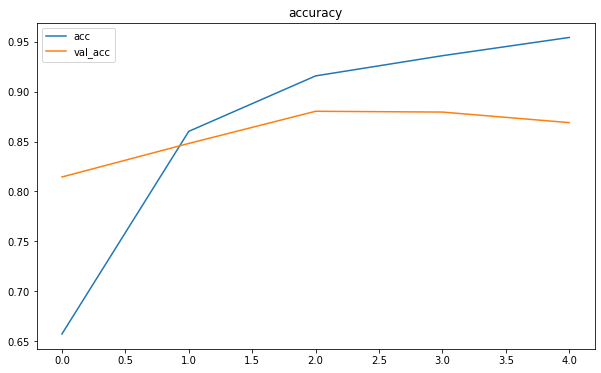

In [25]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

In [29]:
# GRU with 10 units

model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.GRU(10)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 20)                1320      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 21        
Total params: 101,341
Trainable params: 101,341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 97s 442ms/step - loss: 0.6703 - accuracy: 0.5706 - val_loss: 0.3998 - val_accuracy: 0.8307
Epoch 2/5
196/196 [==============================] - 85s 431ms/step - loss: 0.3452 - accuracy: 0.8575 - val_loss: 0.3554 - val_accuracy: 0.8490
Epoch 3/5
196/196 [==============================] - 84s 431ms/step - loss: 0.2606 - accu

391/391 - 20s - loss: 0.3466 - accuracy: 0.8646
accuracy: 86.46%


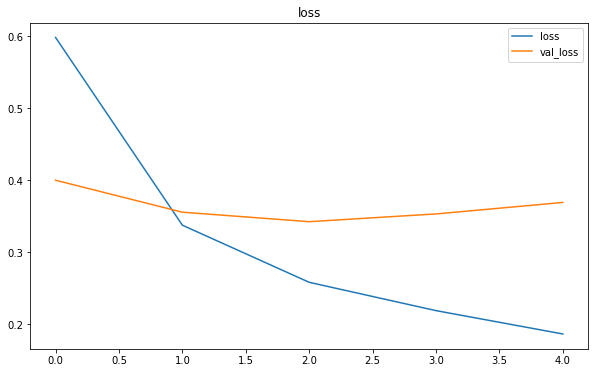

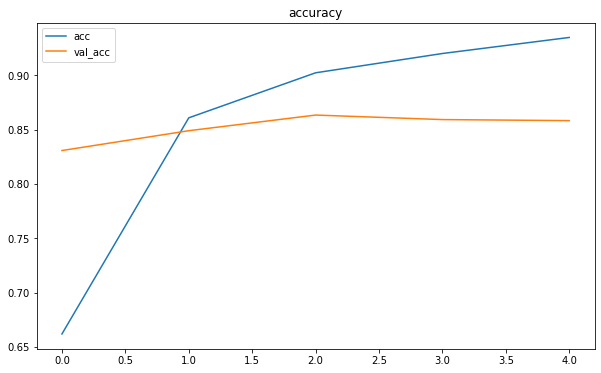

In [30]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

In [32]:
# GRU with 32 units

model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.GRU(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 64)                8448      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 108,513
Trainable params: 108,513
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 190s 915ms/step - loss: 0.6544 - accuracy: 0.5827 - val_loss: 0.3497 - val_accuracy: 0.8541
Epoch 2/5
196/196 [==============================] - 182s 928ms/step - loss: 0.2888 - accuracy: 0.8837 - val_loss: 0.3328 - val_accuracy: 0.8594
Epoch 3/5
196/196 [==============================] - 175s 893ms/step - loss: 0.2179 - a

391/391 - 20s - loss: 0.3565 - accuracy: 0.8632
accuracy: 86.32%


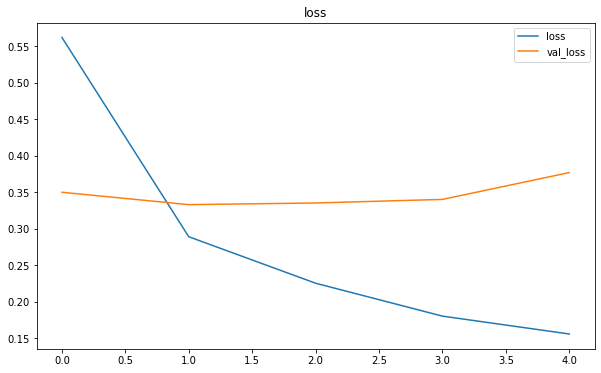

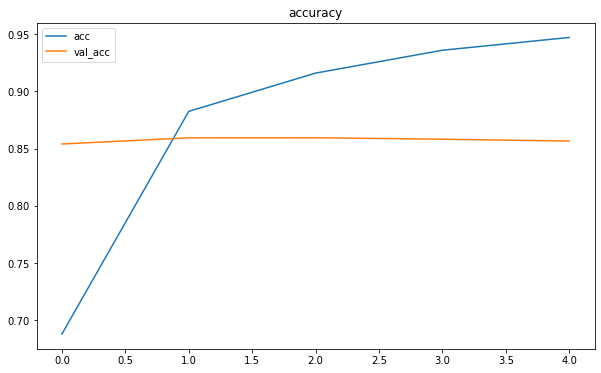

In [33]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

## RNN vs LSTM vs GRU

Comparing the regular RNN to the LSTM and GRU we can observe a difference in overfitting. The overfitting in the regular RNN is more prevalent than in the LSTM and GRU. Never the less, both the LSTM and GRU are also overfitting the data. 

Designing the models on roughly the same number of parameters we ended up using 8 LSTM units and 10 GRU units. Furthermore we decided to use 32 units as well to replicate the number of units used in the RNN and observe the difference between the different LSTM and GRU models. Judging from the graphs it seems like there is no significant improvement when adding more units. 

Finally we observe that the training time for the LSTM and GRU are roughly twice the time of the RNN (when designing on similar number of parameters) (when adding more units to the LSTM and GRU the training time obviosly increases). This difference suprises me as the number of parameters are roughly the same, give or take. One explanation as to why that is could be the gates we have introduced in the LSTM and GRU, which have an activation function associated. Taking derivatives of these function during back propagation could result in the increased run time.

## Exercise 4.3: Dropout
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In Keras, to apply dropout you have to add a [keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer.

We modify the code of the previous exercise adding the Dropout to the input and/or output layers. Find the Dropout probability that reduces the overfitting issue.

Is it possible to modify the values of some other hyper-parameters to mitigate overfitting? And if this is the case, explain why and perform an experimental study demonstrating your point.

*insert cells (code and text) with results and discussion immediately after this cell*

In [49]:
# LSTM with 8 units using dropout

model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Dropout(0.8))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(8)))
model_bidirectional.add(keras.layers.Dropout(0.8))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 10)          0         
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 16)                1216      
_________________________________________________________________
dropout_14 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 17        
Total params: 101,233
Trainable params: 101,233
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 49s 228ms/step - loss: 0.6934 - accuracy: 0.4975 - val_loss

391/391 - 11s - loss: 0.2939 - accuracy: 0.8851
accuracy: 88.51%


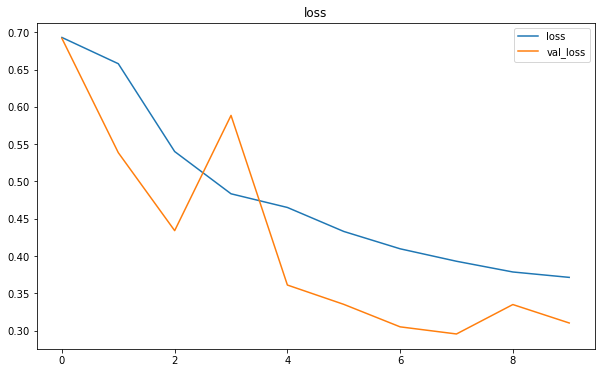

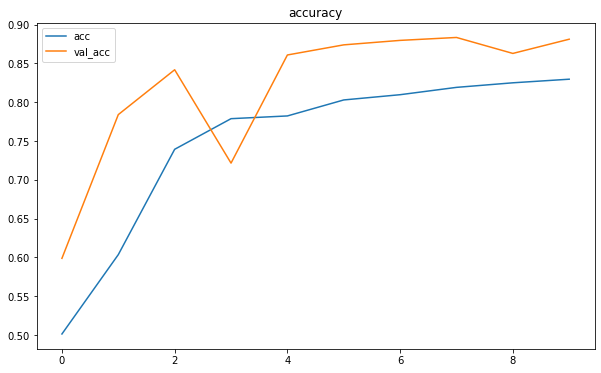

In [50]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

In [53]:
# GRU with 10 units

model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Dropout(0.7))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.GRU(10)))
model_bidirectional.add(keras.layers.Dropout(0.7))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
dropout_17 (Dropout)         (None, None, 10)          0         
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 20)                1320      
_________________________________________________________________
dropout_18 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 21        
Total params: 101,341
Trainable params: 101,341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 81s 398ms/step - loss: 0.6922 - accuracy: 0.5088 - val_loss

391/391 - 11s - loss: 0.2880 - accuracy: 0.8852
accuracy: 88.52%


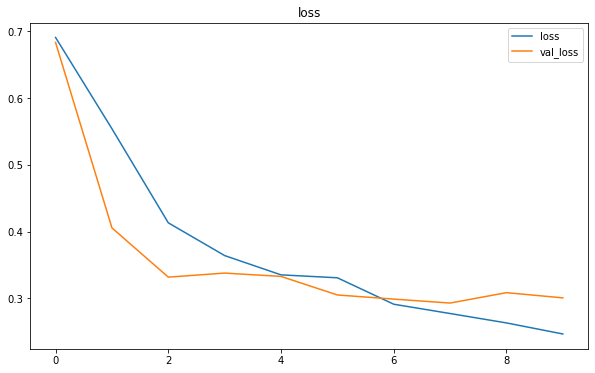

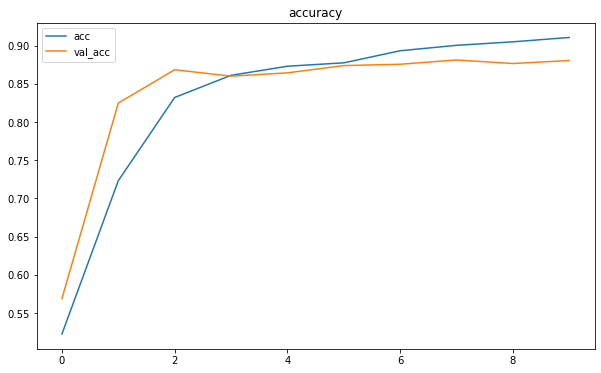

In [54]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

### What can we observe when using dropout?

Judging from the test with GRU using dropout with probability of 0.7 on both input and output reduced the overfitting. By trial and error we found out that by using a lower probability for dropout resulted in overfitting after fewer epochs. 

From the results above we can observe that the model with LSTM and dropout probability 0.8 is less overfitting than with the GRU at 0.7. This result is important as it shows us that by introducing a higher probability of overfitting it requires an increased amount of epochs to reach overfitting. 

Worth noting here is that we have also changed the hyperparameter that is epochs. Sticking with epochs=5 would not require as high a probability of dropout.

Other hyperparameters that could influence the observed overfitting earlier are:
* Number of units in the bidirectional layer.
* Learning rate
* Output activation
* Loss function
* Number of output neurons

Because of these possibilities we experiment with a multiclass classification problem by expanding the output layer to contain 10 neurons and altering the loss function. This test will only be conducted on the LSTM. Note that in order to compare the output and target we need to use the *'sparse_categorical_crossentropy'* function. 

In [63]:
# LSTM with 8 units

model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Dropout(0.8))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(10)))
model_bidirectional.add(keras.layers.Dropout(0.8))
model_bidirectional.add(keras.layers.Dense(10, activation="softmax"))

model_bidirectional.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
dropout_23 (Dropout)         (None, None, 10)          0         
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 20)                1680      
_________________________________________________________________
dropout_24 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 10)                210       
Total params: 101,890
Trainable params: 101,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 62s 296ms/step - loss: 1.7330 - accuracy: 0.3902 - val_loss

391/391 - 20s - loss: 0.5375 - accuracy: 0.8463
accuracy: 84.63%


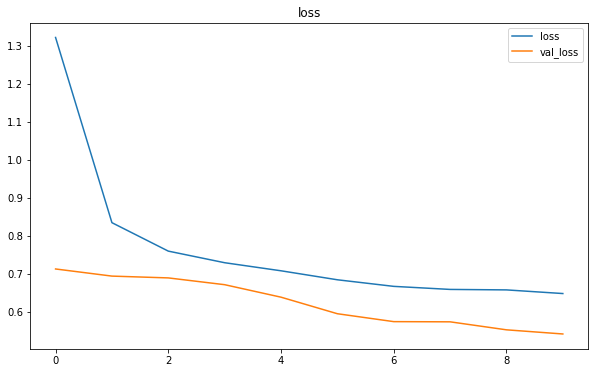

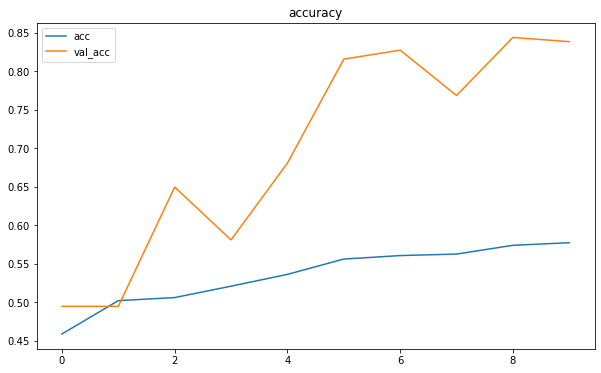

In [64]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

Judging from the plots it seems like the model is very underfitting and happens to be very good at random guessing. During the training process it does not look like the model learn from the data.

I still have faith that a multi-class clasification problem can at least obtain the same performance as the binary classification problem. Hence, I try again by adjusting the dropout rate and the epochs.

In [67]:
# LSTM with 8 units

model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Dropout(0.7))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(10)))
model_bidirectional.add(keras.layers.Dropout(0.7))
model_bidirectional.add(keras.layers.Dense(10, activation="softmax"))

model_bidirectional.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=15, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
dropout_27 (Dropout)         (None, None, 10)          0         
_________________________________________________________________
bidirectional_38 (Bidirectio (None, 20)                1680      
_________________________________________________________________
dropout_28 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 10)                210       
Total params: 101,890
Trainable params: 101,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
196/196 [==============================] - 54s 257ms/step - loss: 1.7274 - accuracy: 0.4092 - val_loss

391/391 - 11s - loss: 0.3074 - accuracy: 0.8746
accuracy: 87.46%


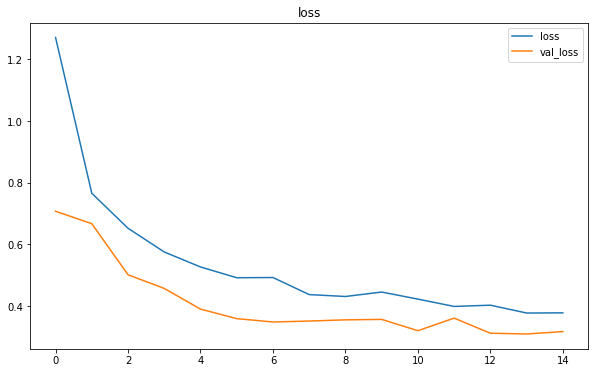

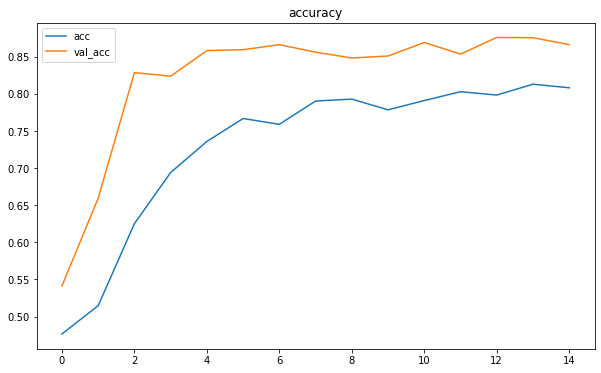

In [68]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

Now, judging from these plots it still looks like the model is underfitting and good at random guessing. However, the results are promosing compared to the previous formulated multi class classification problem. 

It is worth noting that the multi class classification problem still performs worse than the LSTM and GRU version of the binary classification problem. 

Out of curiosity I will try to add more epochs and slightly increase the dropout rate. 

In [71]:
# LSTM with 8 units

model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Dropout(0.75))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(10)))
model_bidirectional.add(keras.layers.Dropout(0.75))
model_bidirectional.add(keras.layers.Dense(10, activation="softmax"))

model_bidirectional.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=30, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
dropout_31 (Dropout)         (None, None, 10)          0         
_________________________________________________________________
bidirectional_40 (Bidirectio (None, 20)                1680      
_________________________________________________________________
dropout_32 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 10)                210       
Total params: 101,890
Trainable params: 101,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
196/196 [==============================] - 85s 391ms/step - loss: 1.6858 - accuracy: 0.4070 - val_loss

391/391 - 18s - loss: 0.3096 - accuracy: 0.8820
accuracy: 88.20%


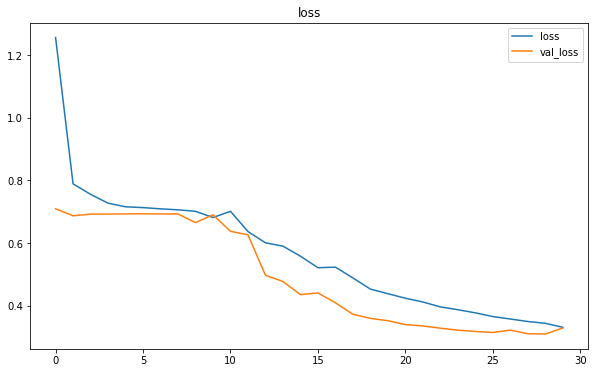

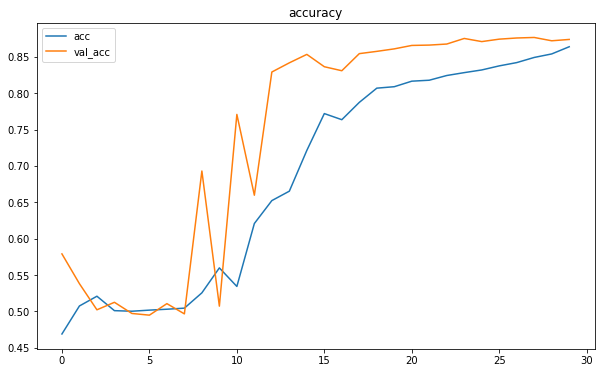

In [72]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

With this model the result is very similar to the best results obtained. This makes me believe that formulating the problem as a multi class classification problem can be made even better. However, comparing a multi class problem to a binary problem, it is more uncertain as to what performs better in this case. 